In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import openpyxl
import xlrd
import statsmodels.api as sm
import statsmodels.stats.api as sms
import scipy.stats as stats

print("All required libraries are installed!")

All required libraries are installed!


In [25]:
df = pd.read_excel("ie_data.xls", sheet_name="Data", skiprows=7, engine="xlrd") 
print(df.columns)

Index(['Date', 'P', 'D', 'E', 'CPI', 'Fraction', 'Rate GS10', 'Price',
       'Dividend', 'Price.1', 'Earnings', 'Earnings.1', 'CAPE', 'Unnamed: 13',
       'TR CAPE', 'Unnamed: 15', 'Yield', 'Returns', 'Returns.1',
       'Real Return', 'Real Return.1', 'Returns.2'],
      dtype='object')


In [26]:
# we select only relevant columns 
df = df[['Fraction', 'Price', 'Earnings', 'CAPE', 'Real Return']] 
# and immediately rename them
df.columns = ['date_fraction', 'real_price', 'real_earnings', 'cape_ratio', 'stock_return_10y']

In [27]:
df.iloc[:, 1:] = df.iloc[:, 1:].apply(pd.to_numeric, errors='coerce') #except for date everything is converted to right format
df = df.dropna()


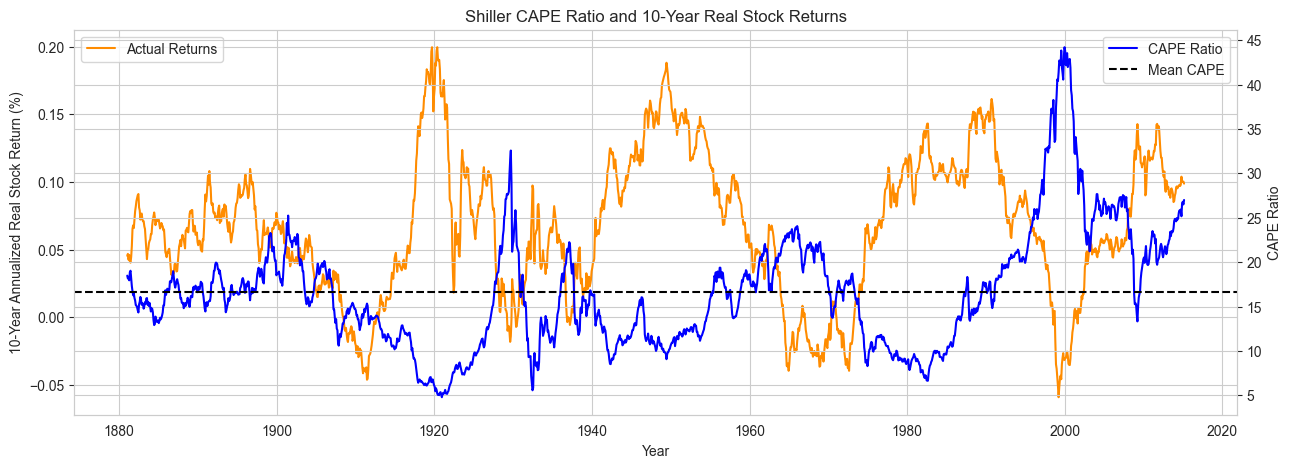

In [29]:

fig, ax1 = plt.subplots(figsize=(15, 5))
ax2 = ax1.twinx() 
#we plot that data that is available to identtify the pattern and look into it

sns.lineplot(data =df, x="date_fraction", y="cape_ratio", ax=ax2, color="blue", label="CAPE Ratio")
ax2.set_ylabel("CAPE Ratio")
ax2.axhline(df["cape_ratio"].mean(), linestyle="--", color="black", label="Mean CAPE")

sns.lineplot(data=df, x="date_fraction", y="stock_return_10y", ax=ax1, color="darkorange", label="Actual Returns")
ax1.set_ylabel("10-Year Annualized Real Stock Return (%)")
ax1.set_xlabel("Year")
ax1.set_title("Shiller CAPE Ratio and 10-Year Real Stock Returns")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.show()


In [30]:
df["stock_return_10y"] *= 100  #we convert to % 

What can be read from the graph above, is the opposite behavior of cape to the returns. The following plot will assess the correlation between these 2 variables, indicating strong negative correlation. This actually reflects the countercyclical nature of the CAPE ratio, since projecting its behavior on the global market, it will act as high during economic expansions, and vice versa (Goyal and Welch, 2022).









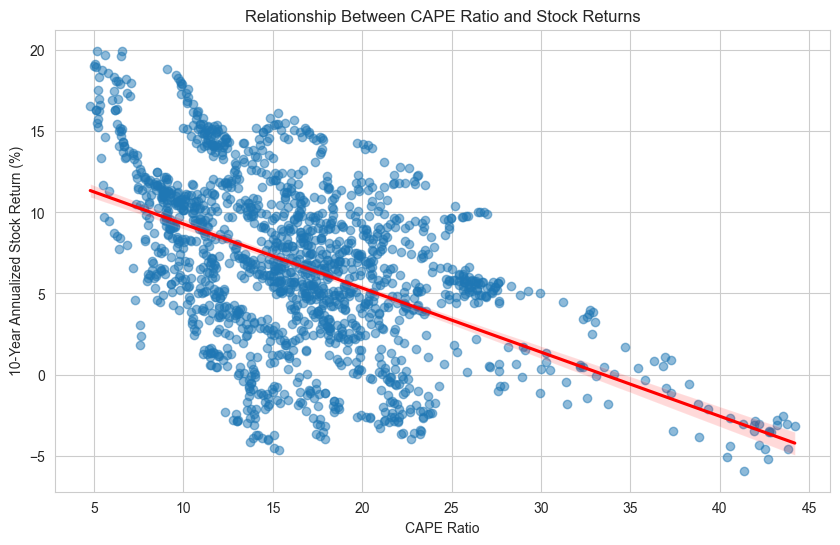

In [37]:

plt.figure(figsize=(10, 6))
sns.regplot(data=df, x="cape_ratio", y="stock_return_10y", scatter_kws={"alpha": 0.5}, line_kws={"color": "red"})

# Labels and title
plt.xlabel("CAPE Ratio")
plt.ylabel("10-Year Annualized Stock Return (%)")
plt.title("Relationship Between CAPE Ratio and Stock Returns")

plt.show()


***
### Regression

                            OLS Regression Results                            
Dep. Variable:       stock_return_10y   R-squared:                       0.277
Model:                            OLS   Adj. R-squared:                  0.277
Method:                 Least Squares   F-statistic:                     617.3
Date:                Wed, 05 Mar 2025   Prob (F-statistic):          1.37e-115
Time:                        17:19:24   Log-Likelihood:                -4661.1
No. Observations:                1610   AIC:                             9326.
Df Residuals:                    1608   BIC:                             9337.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.4228      0.762     33.350      0.0

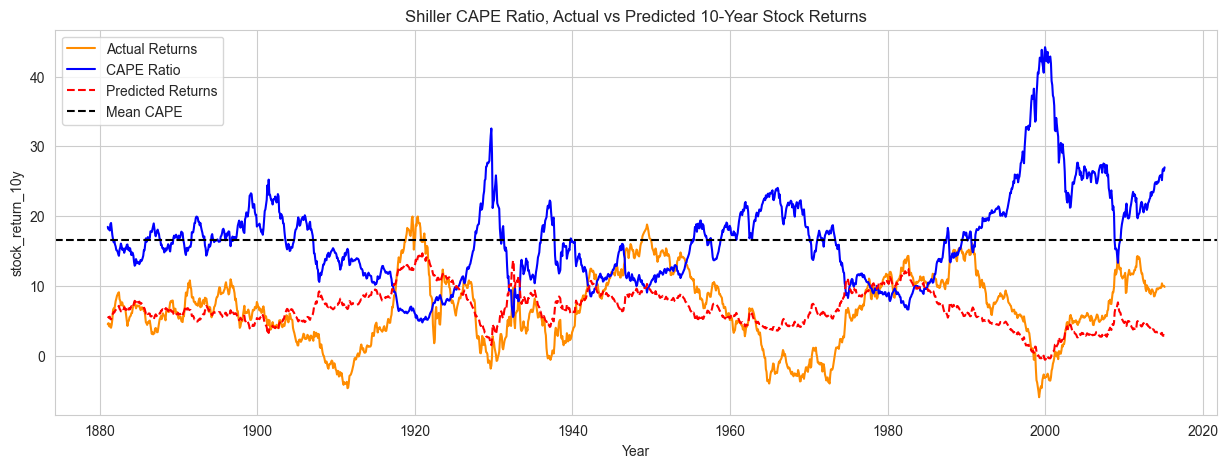

In [38]:

X = sm.add_constant(np.log(df["cape_ratio"]))
y = df["stock_return_10y"]
model = sm.OLS(y, X).fit()
print(model.summary())
df["predicted_stock_return"] = model.predict(X)



plt.figure(figsize=(15, 5))
sns.lineplot(df, x="date_fraction", y="stock_return_10y", color="darkorange", label="Actual Returns")
sns.lineplot(df, x="date_fraction", y="cape_ratio", color="blue", label="CAPE Ratio")
sns.lineplot(df, x="date_fraction", y="predicted_stock_return", color="red", linestyle="dashed", label="Predicted Returns")

plt.axhline(df["cape_ratio"].mean(), linestyle="--", color="black", label="Mean CAPE")

plt.xlabel("Year")
plt.title("Shiller CAPE Ratio, Actual vs Predicted 10-Year Stock Returns")
plt.legend()
plt.show()


#### Test for Autocorrelation

In [39]:
dw = sm.stats.stattools.durbin_watson(model.resid)
print("\n Durbin-Watson Test:", dw)



 Durbin-Watson Test: 0.01162230401950315


inside the allowable range (ca. 2), lower means, as in our case, severe positive autocorrelation, which clearly can be interpreted that which suggests that stock return deviations from the model are following a pattern, namely that past errors tend to predict future errors, which contradicts the assumption that stock returns are independently distributed.
as partially covered in the paper (other arguments mentioned and named) -  if errors are autocorrelated, the model might be missing key macroeconomic factors (business cycles, liquidity effects, etc.)
- unreliability as forecasted returns will systematically overestimate or underestimate actual returns.

if we look at the regression output
- even though statistically significant (exploratory level as well), soley relying on the model (as partially proven in the paper) is irrational
***
#### Residuals behavior

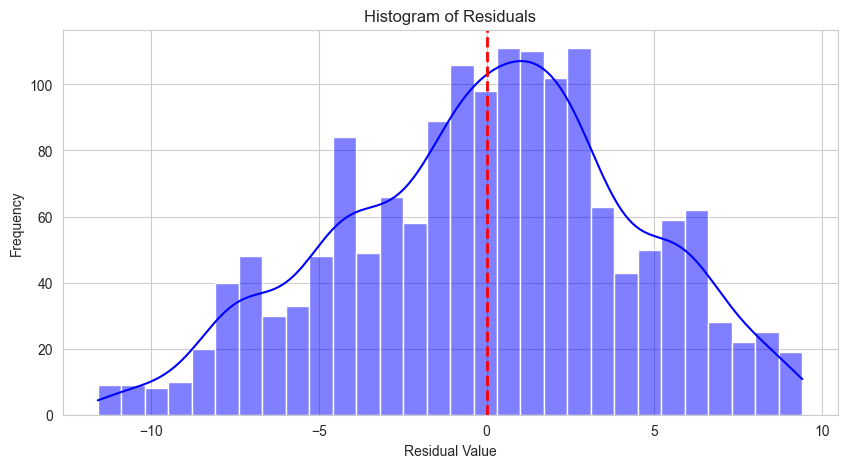

In [40]:
residuals = model.resid
plt.figure(figsize=(10, 5))
sns.histplot(residuals, kde=True, bins=30, color="blue")
plt.axvline(residuals.mean(), color='red', linestyle='dashed', linewidth=2)
plt.title("Histogram of Residuals")
plt.xlabel("Residual Value")
plt.ylabel("Frequency")
plt.show()

What is mainly imporant here not the behavior of the distribution or patterns, but rather the mean of the residuals. Since it is around 0, it means that the model does not exhibit the significant bias, backing up the idea of predicting the values with cape ratio.
*** 
## Trading Strategy

strategy 
lets lay out the structure of the srategy
1) prepare the data
2) play around, do explorative analysis to identify the behavior
    2.1. identification of the idea behind
    2.2 approaches to implement 
    2.3 implementation, plotting, exploration

#### Step 1

The approaches that could be taken to identify the threshold that would be the starting point of our model vary. 
Initially, the static approach is not to be considered a reliable one in the valuations like CAPE (Campbell & Shiller, 1998).
However, to highlight the difference in the later stages, the following code will show it.

The sensitivity parameter is selected 0.5 as mentioned and referenced in the paper(Shiller, 2000).

In [41]:
mean = df["cape_ratio"].mean() 
stdev = df["cape_ratio"].std() 
th_u_static = mean + (stdev * 0.5) 
th_d_static = mean - (stdev * 0.5)  

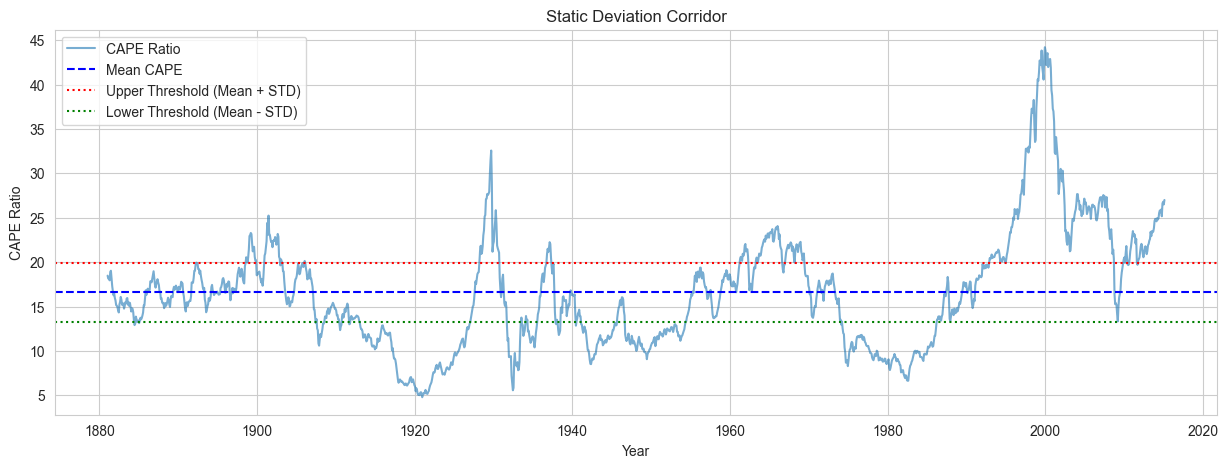

In [42]:
plt.figure(figsize=(15,5))
plt.plot(df["date_fraction"], df["cape_ratio"], label="CAPE Ratio", alpha=0.6)
plt.axhline(y=mean, color="blue", linestyle="--", label="Mean CAPE")
plt.axhline(y=th_u_static, color="red", linestyle="dotted", label="Upper Threshold (Mean + STD)")
plt.axhline(y=th_d_static, color="green", linestyle="dotted", label="Lower Threshold (Mean - STD)")
plt.legend()
plt.title("Static Deviation Corridor")
plt.xlabel("Year")
plt.ylabel("CAPE Ratio")
plt.grid(True)
plt.show()


As the next method, I employed what could be relevant to consider statistically, namely,  quantile-based approach. historical 25th and 75th quantiles are a smart decision partially, since it can try to capture extreme overvaluation and undervaluation by adjusting thresholds based on the distribution of CAPE values rather than a fixed mean.
However, as mentioned before, it will be clear from the graph how the cyclicality of trends is ignored.

The data in our case is not stationary to be employing this method.

In [43]:
df["cape_ma60"] = df["cape_ratio"].rolling(window=60).mean() 
cape_std = df["cape_ratio"].rolling(window=60).std() 

COEF = 0.5  
threshold_u = df["cape_ma60"] + (cape_std * COEF) 
threshold_d = df["cape_ma60"] - (cape_std * COEF) 
quantile_25 = df["cape_ratio"].quantile(0.25)  
quantile_75 = df["cape_ratio"].quantile(0.75)  


*** 
#### Distribution 

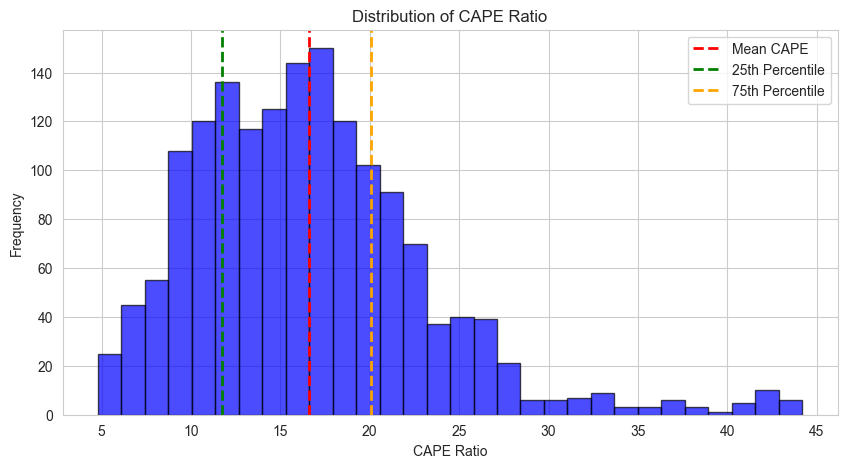

In [ ]:

plt.figure(figsize=(10,5))
plt.hist(df["cape_ratio"], bins=30, alpha=0.7, color="blue", edgecolor="black")
plt.axvline(df["cape_ratio"].mean(), color="r", linestyle="dashed", linewidth=2, label="Mean CAPE")
plt.axvline(df["cape_ratio"].quantile(0.25), color="g", linestyle="dashed", linewidth=2, label="25th Percentile")
plt.axvline(df["cape_ratio"].quantile(0.75), color="orange", linestyle="dashed", linewidth=2, label="75th Percentile")
plt.legend()
plt.title("Distribution of CAPE Ratio")
plt.xlabel("CAPE Ratio")
plt.ylabel("Frequency")
plt.show()


The graph above serves as visual explanation of the distribution of the cape ratio. In our case it is right-skewed (higher CAPE are less frequent). The majority of the data points are in the IQR - so-called normal market conditions.
<br>
Outside of range are the values that are triggering either buying or selling signals.
<br>
The distribution exhibits fat-tail behavior, interpreted as extreme values being more frequent than expected. The nature behind are macroeconomic speculation and central bank policies. Market distortion happens because of investor anticipation and monetary tools in action (Galí, 2014; Shiller, 2000).

Look at Jarque-Beta value in the regression to identify this as well

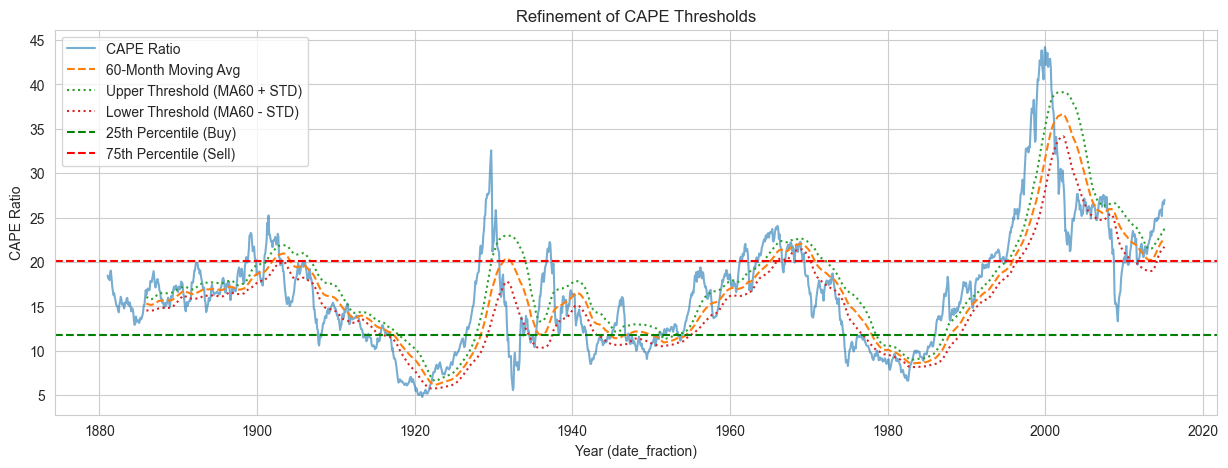

In [44]:
plt.figure(figsize=(15,5))
plt.plot(df["date_fraction"], df["cape_ratio"], label="CAPE Ratio", alpha=0.6)
plt.plot(df["date_fraction"], df["cape_ma60"], label="60-Month Moving Avg", linestyle="--")
plt.plot(df["date_fraction"], threshold_u, label="Upper Threshold (MA60 + STD)", linestyle="dotted")
plt.plot(df["date_fraction"], threshold_d, label="Lower Threshold (MA60 - STD)", linestyle="dotted")
plt.axhline(y=quantile_25, color="g", linestyle="dashed", label="25th Percentile (Buy)")
plt.axhline(y=quantile_75, color="r", linestyle="dashed", label="75th Percentile (Sell)")
plt.legend()
plt.title("Refinement of CAPE Thresholds")
plt.xlabel("Year (date_fraction)")
plt.ylabel("CAPE Ratio")
plt.grid(True)
plt.show()


The graph as well as the code above show the 2. and 3. approaches. 
Last method is basically based off on the central macroeconomic concepts. We select the 60-month rolling moving average for the reason of detecting structural valuation shifts without overreacting to short-term volatility. 
***
### Argumentation
As Burns&Mitchell (1946) proved as well as theoretically clear, the selection of too short timeframe gives short signals, while 60 months (5 years) aligns well with macroeconomic conditions - business cycle. And as critisized in the paper of selecting the fixed historical mean (Siegel, 2016). 
(also compared below with 12-month to prove on our example) - captures smaller range

In [45]:

df["cape_ma12"] = df["cape_ratio"].rolling(window=12).mean()  
cape_std_12 = df["cape_ratio"].rolling(window=12).std() 
threshold_u_12 = df["cape_ma12"] + (cape_std_12 * COEF) 
threshold_d_12 = df["cape_ma12"] - (cape_std_12 * COEF) 

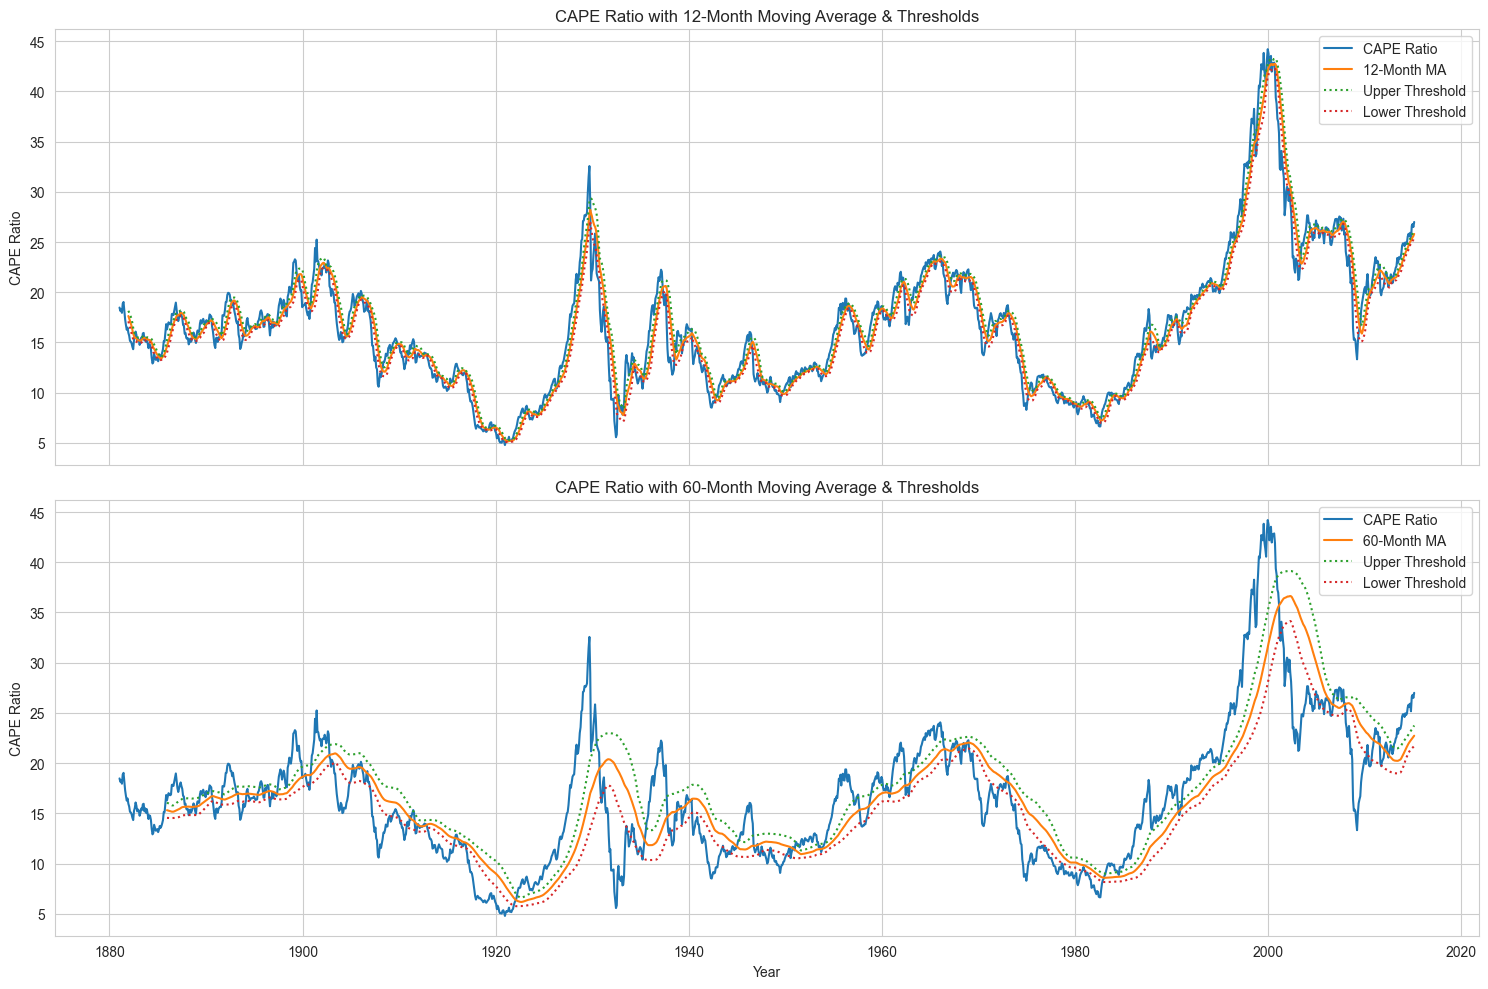

In [46]:
sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

sns.lineplot(data=df, x="date_fraction", y="cape_ratio", label="CAPE Ratio", ax=axes[0])
sns.lineplot(data=df, x="date_fraction", y="cape_ma12", label="12-Month MA", ax=axes[0])
sns.lineplot(data=df, x="date_fraction", y=threshold_u_12, label="Upper Threshold", linestyle="dotted", ax=axes[0])
sns.lineplot(data=df, x="date_fraction", y=threshold_d_12, label="Lower Threshold", linestyle="dotted", ax=axes[0])
axes[0].set_title("CAPE Ratio with 12-Month Moving Average & Thresholds")
axes[0].set_ylabel("CAPE Ratio")
axes[0].legend()

sns.lineplot(data=df, x="date_fraction", y="cape_ratio", label="CAPE Ratio", ax=axes[1])
sns.lineplot(data=df, x="date_fraction", y="cape_ma60", label="60-Month MA", ax=axes[1])
sns.lineplot(data=df, x="date_fraction", y=threshold_u, label="Upper Threshold", linestyle="dotted", ax=axes[1])
sns.lineplot(data=df, x="date_fraction", y=threshold_d, label="Lower Threshold", linestyle="dotted", ax=axes[1])
axes[1].set_title("CAPE Ratio with 60-Month Moving Average & Thresholds")
axes[1].set_xlabel("Year")
axes[1].set_ylabel("CAPE Ratio")
axes[1].legend()

plt.tight_layout()
plt.show()


SD in our case is a perfect measure to identify the so-called deviation corridor, where the moving average
`cape_ma60` acts as a *baseline* and the threshold has a role of an adaptive channel, which acts on market volatility (capturing the fluctutations).
<br>
The validation of the efficiency of the selected approach is required, thus, I compare the behavior to the market prices (to ensure that it is not a random noise but some cycles are captured)(Burns & Mitchell, 1946; Campbell & Shiller, 1998).

#### Signalling 
On the same graph the signals to either *sell* or *buy* will be implemented.

<br>
Buy Signal (Undervaluation) - When CAPE is below the lower threshold, cheap market conditions.
<br>
Sell Signal (Overvaluation) - When CAPE is over the upper threshold, expensive market conditions.

In [14]:
df["Buy_Signal"] = (df["cape_ratio"] < threshold_d)  # idea behind is to buy when CAPE crosses below lower bound
df["Sell_Signal"] = (df["cape_ratio"] > threshold_u)  # and to sell when CAPE crosses above upper bound

# we take out the dates exactly when these have happened to mark on the graph
buy_dates = df.loc[df["Buy_Signal"], "date_fraction"]
sell_dates = df.loc[df["Sell_Signal"], "date_fraction"]
buy_cape = df.loc[df["Buy_Signal"], "cape_ratio"]
sell_cape = df.loc[df["Sell_Signal"], "cape_ratio"]

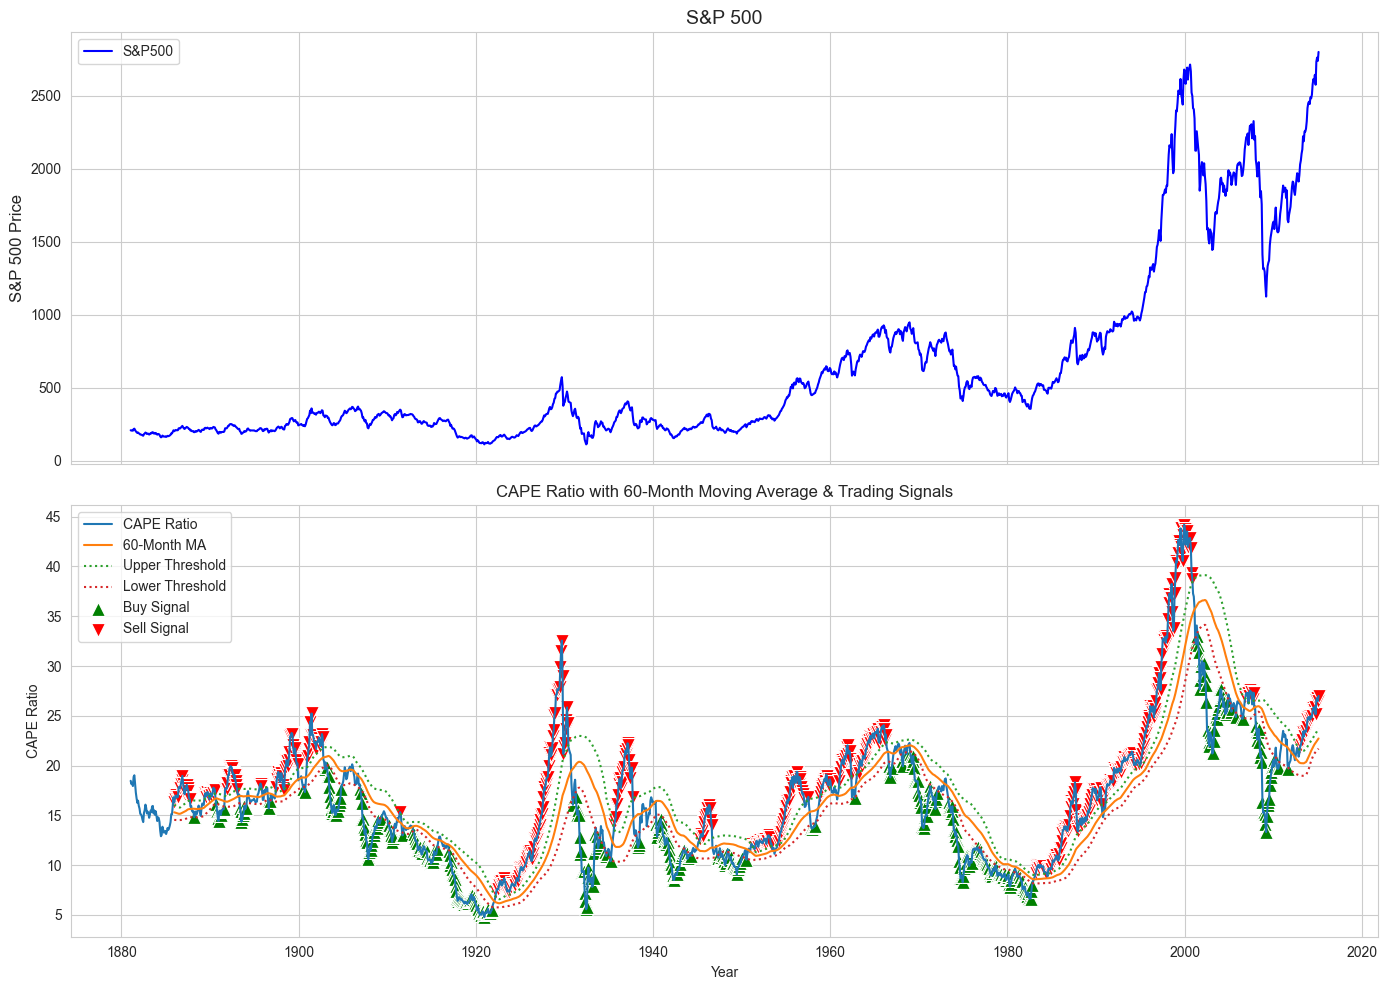

In [15]:
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
sns.lineplot(x=df["date_fraction"], y=df["real_price"], label="S&P500", color="blue", ax=axes[0])
axes[0].set_title("S&P 500", fontsize=14)
axes[0].set_ylabel("S&P 500 Price", fontsize=12)
axes[0].legend(loc="upper left")


sns.lineplot(data=df, x="date_fraction", y="cape_ratio", label="CAPE Ratio", ax=axes[1])
sns.lineplot(data=df, x="date_fraction", y="cape_ma60", label="60-Month MA", ax=axes[1])
sns.lineplot(data=df, x="date_fraction", y=threshold_u, label="Upper Threshold", linestyle="dotted", ax=axes[1])
sns.lineplot(data=df, x="date_fraction", y=threshold_d, label="Lower Threshold", linestyle="dotted", ax=axes[1])

# signals through scatter plot
sns.scatterplot(x=buy_dates, y=buy_cape, marker="^", color="green", label="Buy Signal", s=100, ax=axes[1])
sns.scatterplot(x=sell_dates, y=sell_cape, marker="v", color="red", label="Sell Signal", s=100, ax=axes[1])

axes[1].set_title("CAPE Ratio with 60-Month Moving Average & Trading Signals")
axes[1].set_xlabel("Year")
axes[1].set_ylabel("CAPE Ratio")
axes[1].legend()
plt.tight_layout()
plt.show()
